# Assignment 3 Part 2
Grayson Hineline

Note for portfolio: This is a fun project. In this Part 1, I am tasked with slicing the images in two videos to reconstruct the photos. If you think of an image as a a bunch of images stacked on top of each other to form a box, these tasks were to out parts of that box in a slice such that an entirely new, warped image could be formed.

Import the things we'll need:

In [62]:
import pandas as pd
import numpy as np
import imageio
import matplotlib.pyplot as plt
import seaborn as sns

From the professor: The following CSV file contains an index of all the images you have to work with. It has columns for just the Filename and the full URL where the image lives.

In [63]:
image_index = pd.read_csv("https://facultyweb.cs.wwu.edu/~wehrwes/courses/data311_21f/data/ecu-per.csv")
image_index

,Filename,URL
0,ecu-per-00000.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
1,ecu-per-00001.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
2,ecu-per-00002.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
3,ecu-per-00003.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
4,ecu-per-00004.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
...,...,...
3348,ecu-per-03350.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
3349,ecu-per-03351.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
3350,ecu-per-03352.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
3351,ecu-per-03353.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...


From the professor: Your job is to augment the `image_index` DataFrame with an additional column called `Inlier` with type `bool` which is `True` if that row corresponds to a real image (i.e, is an inlier), and `False` if it corresponds to a bogus image (i.e., an outlier).

--------------------------------------------------------------------------

First I want to look at a random sample of 10 images just to see what most of them look like.

In [64]:
samplen10 = image_index.sample(n=10).reset_index()

In [65]:
samplen10

,index,Filename,URL
0,247,ecu-per-00247.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
1,271,ecu-per-00271.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
2,15,ecu-per-00015.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
3,2003,ecu-per-02003.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
4,2599,ecu-per-02601.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
5,1391,ecu-per-01391.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
6,2215,ecu-per-02216.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
7,1716,ecu-per-01716.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
8,3042,ecu-per-03044.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...
9,2475,ecu-per-02477.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...


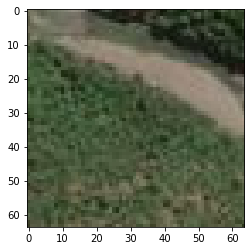

In [66]:
plt.imshow(imageio.imread(samplen10["URL"][1])) 

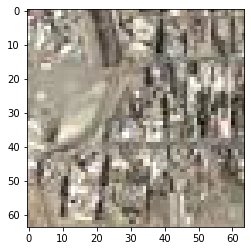

In [67]:
plt.imshow(imageio.imread(samplen10["URL"][2]))

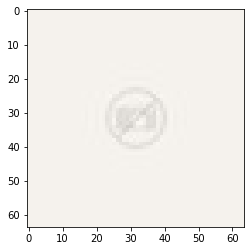

In [68]:
plt.imshow(imageio.imread(samplen10["URL"][3])) #outlier

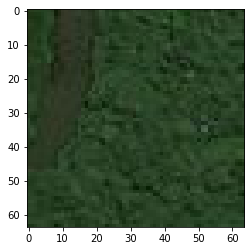

In [69]:
plt.imshow(imageio.imread(samplen10["URL"][4]))

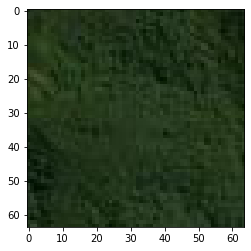

In [70]:
plt.imshow(imageio.imread(samplen10["URL"][5]))

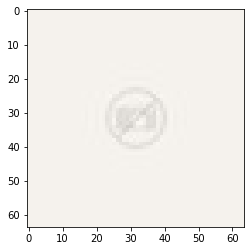

In [71]:
plt.imshow(imageio.imread(samplen10["URL"][6])) #outlier

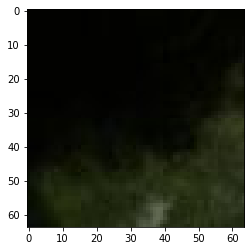

In [72]:
plt.imshow(imageio.imread(samplen10["URL"][7]))

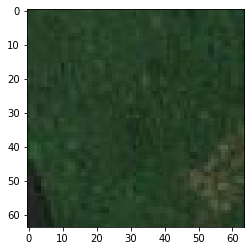

In [73]:
plt.imshow(imageio.imread(samplen10["URL"][8]))

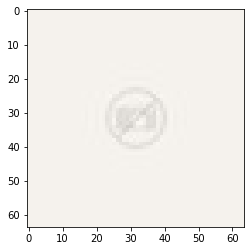

In [74]:
plt.imshow(imageio.imread(samplen10["URL"][9])) #outlier

Well look at that, just by looking at a random sample of 10 images we found some outliers. Lets look at the properties of those rows vs some of the rows we know are fine from the images we just printed.

In [75]:
# In the random sample the weird rows 3, 6 and 9 were originally rows 2003, 2482, and 2475 respectively
weirdImage = imageio.imread(image_index["URL"][2003])
weirdImage

Array([[[245, 242, 237],
        [245, 242, 237],
        [245, 242, 237],
        ...,
        [245, 242, 237],
        [245, 242, 237],
        [245, 242, 237]],

       [[245, 242, 237],
        [245, 242, 237],
        [245, 242, 237],
        ...,
        [245, 242, 237],
        [245, 242, 237],
        [245, 242, 237]],

       [[245, 242, 237],
        [245, 242, 237],
        [245, 242, 237],
        ...,
        [245, 242, 237],
        [245, 242, 237],
        [245, 242, 237]],

       ...,

       [[245, 242, 237],
        [245, 242, 237],
        [245, 242, 237],
        ...,
        [245, 242, 237],
        [245, 242, 237],
        [245, 242, 237]],

       [[245, 242, 237],
        [245, 242, 237],
        [245, 242, 237],
        ...,
        [245, 242, 237],
        [245, 242, 237],
        [245, 242, 237]],

       [[245, 242, 237],
        [245, 242, 237],
        [245, 242, 237],
        ...,
        [245, 242, 237],
        [245, 242, 237],
        [245, 242, 237]]

From just looking at the values, it looks like they're all the same numbers. Let's look at a bunch of summary statistics to see whats going on.

Making a function that returns some summary statistics of a given array:

In [76]:
def sumStats(array):
    sumDict = {
        "Count non-zero" : np.count_nonzero(array),
        "Standard Deviation" : np.std(array),
        #Sum" : np.sum(array), realized I can't include the sum or else it makes the numbers in the series too big
        "Mean" : np.mean(array),
        "Median" : np.median(array),
        "Min" : np.amin(array),
        "Max" : np.amax(array)
    }
    return pd.Series(sumDict)

Now lets use this function on the arrays we just tested

In [77]:
sumStats(weirdImage)

Count non-zero        12288.000000
Standard Deviation        4.851529
Mean                    240.626058
Median                  242.000000
Min                     201.000000
Max                     251.000000
dtype: float64

So all of the values are between 200 and 251, and the average is 241.

In [78]:
weirdImage2 = imageio.imread(image_index["URL"][2215])
sumStats(weirdImage2)

Count non-zero        12288.000000
Standard Deviation        4.851529
Mean                    240.626058
Median                  242.000000
Min                     201.000000
Max                     251.000000
dtype: float64

Same deal. Let's look at one more.

Both of these bogus images had the exact same summary statistics. Let's look at a couple normal ones for comparison

In [79]:
normalImage1 = imageio.imread(image_index["URL"][271])
sumStats(normalImage1)

Count non-zero        12288.000000
Standard Deviation       30.245142
Mean                     79.118815
Median                   77.000000
Min                       1.000000
Max                     172.000000
dtype: float64

In [80]:
normalImage2 = imageio.imread(image_index["URL"][15])
sumStats(normalImage2)

Count non-zero        12287.000000
Standard Deviation       42.162164
Mean                    144.045492
Median                  146.000000
Min                       0.000000
Max                     255.000000
dtype: float64

In [81]:
normalImage3 = imageio.imread(image_index["URL"][2599])
sumStats(normalImage3)

Count non-zero        12286.000000
Standard Deviation       15.159674
Mean                     46.940511
Median                   44.000000
Min                       0.000000
Max                     105.000000
dtype: float64

The means of the normal images are substantially lower. Furthermore, the std's of all of them seem to be mostly much larger as well.

From this sample, I now think that the means of the outlier images are usually different from the means of the normal images. So lets make a column of the means of the images in our dataframe and then plot it.

In [82]:
def getArrayMean(row):
    return np.mean(imageio.imread(row))

getArrayMean(image_index["URL"][2733]) #test

240.62605794270834

In [83]:
image_index["Array Mean"] = image_index["URL"].apply(getArrayMean)
image_index

,Filename,URL,Array Mean
0,ecu-per-00000.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,70.236003
1,ecu-per-00001.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,70.236003
2,ecu-per-00002.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,65.725911
3,ecu-per-00003.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,49.841471
4,ecu-per-00004.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,86.958252
...,...,...,...
3348,ecu-per-03350.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,39.511230
3349,ecu-per-03351.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,56.775472
3350,ecu-per-03352.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,41.453451
3351,ecu-per-03353.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,46.192952


In [84]:
image_index["Array Mean"].describe()

count    3353.000000
mean       96.991364
std        75.856462
min         3.332194
25%        43.954427
50%        62.042480
75%       109.918213
max       254.000000
Name: Array Mean, dtype: float64

<AxesSubplot:xlabel='Array Mean', ylabel='Count'>

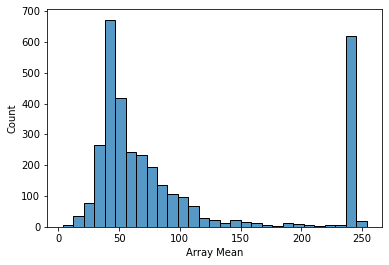

In [85]:
sns.histplot(image_index["Array Mean"])

Well, judging from the shape of this, think I may have found the outliers. Other than the massive amount of outliers with values just below 250, The rest of the dat looks kind of gaussian.

Let's make some z scores for the averages and plot that. 

*Note: In hindsight, I realize that I could have done all of the following analysis on the means instead of the z-scores*

<AxesSubplot:xlabel='Z-Score for Mean', ylabel='Count'>

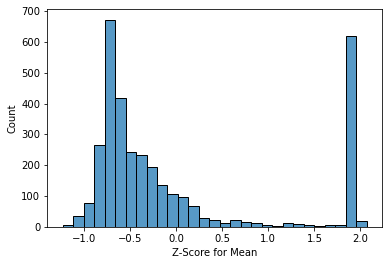

In [86]:
image_index["Z-Score for Mean"] = (image_index["Array Mean"] - image_index["Array Mean"].mean()) /  image_index["Array Mean"].std()
sns.histplot(image_index["Z-Score for Mean"])

In [87]:
image_index["Z-Score for Mean"].describe()

count    3.353000e+03
mean    -9.119226e-15
std      1.000000e+00
min     -1.234689e+00
25%     -6.991749e-01
50%     -4.607239e-01
75%      1.704120e-01
max      2.069812e+00
Name: Z-Score for Mean, dtype: float64

In [88]:
image_index["Z-Score for Mean"].value_counts().sort_values()

-0.235687      1
-0.330609      1
-0.754337      1
-0.607397      1
-0.597081      1
            ... 
 2.069812      2
-0.899772      2
-0.658169      2
-0.680756      2
 1.893506    611
Name: Z-Score for Mean, Length: 2691, dtype: int64

Wow. So the z-scores for 611 images are all 1.8935. I'm pretty sure those are all outliers, but we need to do some testing to make sure.

To see in what ranges the z-score of an image's mean indicates that they're probably bogus, I continuously tested these samples.

First I looked at z-scores over 1

In [89]:
hyp_outliers = image_index[image_index["Z-Score for Mean"] > 1]
hyp_outliers

,Filename,URL,Array Mean,Z-Score for Mean
123,ecu-per-00123.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,200.901611,1.369827
124,ecu-per-00124.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,191.097493,1.240582
1328,ecu-per-01328.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,174.524333,1.022101
1329,ecu-per-01329.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,200.988607,1.370974
1330,ecu-per-01330.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,189.228760,1.215946
...,...,...,...,...
2807,ecu-per-02809.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,226.405924,1.706045
2906,ecu-per-02908.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,197.203613,1.321077
3259,ecu-per-03261.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,228.486491,1.733473
3260,ecu-per-03262.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,253.434570,2.062358


Then I just pulled a random image out of these 686 over and over again to see if it was bogus or not.

In [90]:
sample = hyp_outliers.sample(n=1).reset_index()
sample

,index,Filename,URL,Array Mean,Z-Score for Mean
0,2189,ecu-per-02190.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506


Main df index: 2189


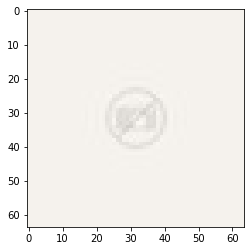

In [91]:
print("Main df index: " + str(sample["index"][0]))
plt.imshow(imageio.imread(sample["URL"][0]))

Importantly, some of the images with z-scores greater than 1 appeared as real images. But one z-score kept recurring for images that were bogus, 1.893506. I decided from this to split the sets I was testing from 1.0-1.7 and from 1.7 and up.

First I did between 1.0 and 1.7

In [92]:
hyp_outliers = image_index[(image_index["Z-Score for Mean"] > 1) & (image_index["Z-Score for Mean"] < 1.7)]
hyp_outliers

,Filename,URL,Array Mean,Z-Score for Mean
123,ecu-per-00123.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,200.901611,1.369827
124,ecu-per-00124.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,191.097493,1.240582
1328,ecu-per-01328.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,174.524333,1.022101
1329,ecu-per-01329.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,200.988607,1.370974
1330,ecu-per-01330.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,189.228760,1.215946
1331,ecu-per-01331.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,202.023926,1.384622
1332,ecu-per-01332.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,199.635905,1.353142
1345,ecu-per-01345.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,203.777832,1.407744
1355,ecu-per-01355.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,213.510254,1.536044
1357,ecu-per-01357.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,200.784180,1.368279


In [93]:
sample = hyp_outliers.sample(n=1).reset_index()
sample

,index,Filename,URL,Array Mean,Z-Score for Mean
0,1368,ecu-per-01368.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,199.762858,1.354815


Main df index: 1368


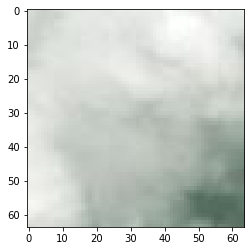

In [94]:
print("Main df index: " + str(sample["index"][0]))
plt.imshow(imageio.imread(sample["URL"][0]))

After testing this a bunch of times, I did not find a single bogus image with a z-score from 1.0 - 1.7. Let's now test 1.7 and up.

In [95]:
hyp_outliers = image_index[image_index["Z-Score for Mean"] > 1.7]
hyp_outliers

,Filename,URL,Array Mean,Z-Score for Mean
1356,ecu-per-01356.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,232.709717,1.789147
1365,ecu-per-01365.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,243.180908,1.927186
1366,ecu-per-01366.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,248.432861,1.996422
1369,ecu-per-01369.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,251.110921,2.031726
1370,ecu-per-01370.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,245.705485,1.960467
...,...,...,...,...
2795,ecu-per-02797.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
2796,ecu-per-02798.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
2807,ecu-per-02809.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,226.405924,1.706045
3259,ecu-per-03261.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,228.486491,1.733473


In [96]:
sample = hyp_outliers.sample(n=1).reset_index()
sample

,index,Filename,URL,Array Mean,Z-Score for Mean
0,2434,ecu-per-02436.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506


Main df index: 2434


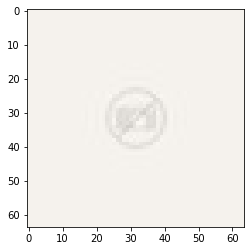

In [97]:
print("Main df index: " + str(sample["index"][0]))
plt.imshow(imageio.imread(sample["URL"][0]))

While almost all of these images tested were bogus, I found couple real images with z-scores above 2.0 and one at 1.789, meaning that it may just be images with z-scores of 1.893 that are bogus. Now I'll test between 1.8 and 1.9:

In [98]:
hyp_outliers = image_index[(image_index["Z-Score for Mean"] > 1.8) & (image_index["Z-Score for Mean"] < 1.9)]
hyp_outliers

,Filename,URL,Array Mean,Z-Score for Mean
1482,ecu-per-01482.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,237.925863,1.857910
1604,ecu-per-01604.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,236.926270,1.844733
1781,ecu-per-01781.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,234.066325,1.807031
1790,ecu-per-01790.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,238.264160,1.862370
1823,ecu-per-01823.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
...,...,...,...,...
2792,ecu-per-02794.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
2793,ecu-per-02795.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
2794,ecu-per-02796.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
2795,ecu-per-02797.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506


In [99]:
hyp_outliers["Z-Score for Mean"].value_counts().sort_index()

1.807031      1
1.816651      1
1.844733      1
1.857910      1
1.862370      1
1.893506    611
Name: Z-Score for Mean, dtype: int64

Aw there's so many of them that testing just the values that are 1.893506 might be smart to conclude that those are just the outliers. Let's test that and then and then quickly test the other 5.

In [100]:
just189values = hyp_outliers[hyp_outliers["Z-Score for Mean"] > 1.87]
just189values

,Filename,URL,Array Mean,Z-Score for Mean
1823,ecu-per-01823.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
1824,ecu-per-01824.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
1825,ecu-per-01825.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
1826,ecu-per-01826.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
1827,ecu-per-01827.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
...,...,...,...,...
2792,ecu-per-02794.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
2793,ecu-per-02795.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
2794,ecu-per-02796.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506
2795,ecu-per-02797.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506


In [101]:
sample = just189values.sample(n=1).reset_index()
sample

,index,Filename,URL,Array Mean,Z-Score for Mean
0,1880,ecu-per-01880.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,240.626058,1.893506


Main df index: 1880


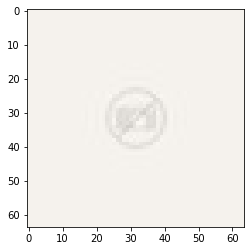

In [102]:
print("Main df index: " + str(sample["index"][0]))
plt.imshow(imageio.imread(sample["URL"][0]))

After a lot of testing, I'm certain that all of these images are outliers.

Lets test the other 5 real quick:

In [103]:
otherValues = hyp_outliers[hyp_outliers["Z-Score for Mean"] < 1.89].reset_index()
otherValues

,index,Filename,URL,Array Mean,Z-Score for Mean
0,1482,ecu-per-01482.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,237.925863,1.857910
1,1604,ecu-per-01604.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,236.926270,1.844733
2,1781,ecu-per-01781.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,234.066325,1.807031
3,1790,ecu-per-01790.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,238.264160,1.862370
4,2067,ecu-per-02067.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,234.796061,1.816651


Main df index: 1482


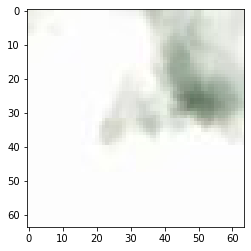

In [104]:
print("Main df index: " + str(otherValues["index"][0]))
plt.imshow(imageio.imread(otherValues["URL"][0]))

Main df index: 1604


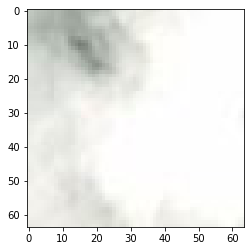

In [105]:
print("Main df index: " + str(otherValues["index"][1]))
plt.imshow(imageio.imread(otherValues["URL"][1]))

Main df index: 1781


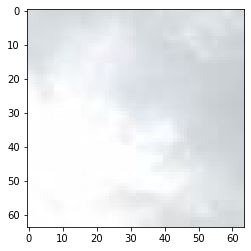

In [106]:
print("Main df index: " + str(otherValues["index"][2]))
plt.imshow(imageio.imread(otherValues["URL"][2]))

Main df index: 1790


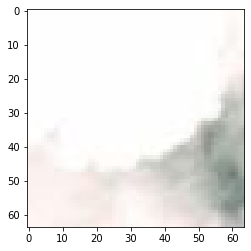

In [107]:
print("Main df index: " + str(otherValues["index"][3]))
plt.imshow(imageio.imread(otherValues["URL"][3]))

Main df index: 2067


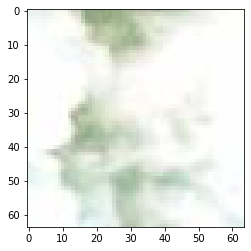

In [108]:
print("Main df index: " + str(otherValues["index"][4]))
plt.imshow(imageio.imread(otherValues["URL"][4]))

Alright, all of those images were not bogus, and the others that had z-scores of 1.89 were. Just to be extra thorough, I want to test the other images above 1.89 as well because those ones are really far from the mean of the set as well.

In [109]:
hyp_outliers = image_index[(image_index["Z-Score for Mean"] > 1.893507)]
hyp_outliers

,Filename,URL,Array Mean,Z-Score for Mean
1365,ecu-per-01365.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,243.180908,1.927186
1366,ecu-per-01366.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,248.432861,1.996422
1369,ecu-per-01369.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,251.110921,2.031726
1370,ecu-per-01370.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,245.705485,1.960467
1379,ecu-per-01379.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,241.873128,1.909946
1483,ecu-per-01483.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,251.304688,2.034281
1631,ecu-per-01631.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,243.153320,1.926823
1633,ecu-per-01633.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,253.334310,2.061037
1634,ecu-per-01634.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,252.173258,2.045731
1783,ecu-per-01783.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,244.582031,1.945657


Main df index: 2542


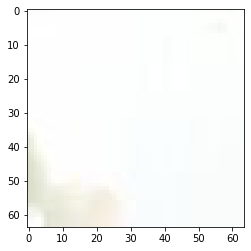

In [110]:
sample = hyp_outliers.sample(n=1).reset_index()
sample
print("Main df index: " + str(sample["index"][0]))
plt.imshow(imageio.imread(sample["URL"][0]))

After testing a bunch, I didn't find any outliers. The reason the scores for all these images are so much higher than the rest is because they are very bright images, therefore the mean of the values in their corresponding arrays are much higher.

So I've determined that **all the images who's mean values for the values inside their corresponding arrays when compared to the average mean of all the arrays have z-scores of approximately 1.893506**.

I would go ahead and make the inlier category right now, but I actually found some other outliers too that dont have these same properties.

All the above analysis is what I did once I really sat down to do this lab, but one day earlier in the week I had a few minutes in between my classes so I was just playing around with this dataset. The first thought I had was to see if I could find any outliers quickly by just looking at the shape of all of the images.
(Note, this is before I had the forethought to only look at a small sample my dataframe, but in this case it worked out because I found only two outliers and I'm unsure if a random sampling would have found them given that there are only two.)

In [111]:
def size(url):
    shape = imageio.imread(url).shape
    return shape

In [112]:
image_index["shape"] = image_index["URL"].apply(size)
image_index

,Filename,URL,Array Mean,Z-Score for Mean,shape
0,ecu-per-00000.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,70.236003,-0.352710,"(64, 64, 3)"
1,ecu-per-00001.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,70.236003,-0.352710,"(64, 64, 3)"
2,ecu-per-00002.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,65.725911,-0.412166,"(64, 64, 3)"
3,ecu-per-00003.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,49.841471,-0.621567,"(64, 64, 3)"
4,ecu-per-00004.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,86.958252,-0.132264,"(64, 64, 3)"
...,...,...,...,...,...
3348,ecu-per-03350.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,39.511230,-0.757749,"(64, 64, 3)"
3349,ecu-per-03351.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,56.775472,-0.530158,"(64, 64, 3)"
3350,ecu-per-03352.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,41.453451,-0.732145,"(64, 64, 3)"
3351,ecu-per-03353.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,46.192952,-0.669665,"(64, 64, 3)"


In [113]:
image_index["shape"].value_counts()

(64, 64, 3)    3351
(64, 64)          2
Name: shape, dtype: int64

Wait, why are their two urls that point to only two dimensional arrays?

In [114]:
image_index[image_index["shape"] == (64,64)]

,Filename,URL,Array Mean,Z-Score for Mean,shape
1785,ecu-per-01785.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,254.0,2.069812,"(64, 64)"
1791,ecu-per-01791.jpeg,https://facultyweb.cs.wwu.edu/~wehrwes/courses...,254.0,2.069812,"(64, 64)"


In [115]:
imageio.imread(image_index["URL"][1785])

Array([[254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       ...,
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254]], dtype=uint8)

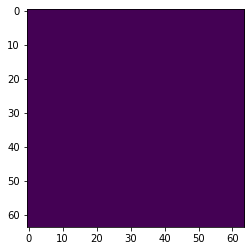

In [116]:
plt.imshow(imageio.imread(image_index["URL"][1785]))

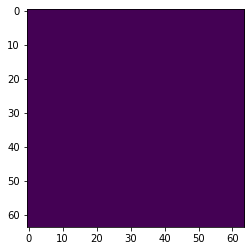

In [117]:
plt.imshow(imageio.imread(image_index["URL"][1791]))

Well these should probably be dropped, they're just purple!

With that out of the way, lets make our inlier column and be done.

**The Inlier column will contain True values for every value that does not have a z-score of (approximately) 1.893506, and also include the outliers above that are just purple.**

In [118]:
mask1 = (image_index["Z-Score for Mean"] < 1.893506) | (image_index["Z-Score for Mean"] > 1.893507)
mask2 = image_index["shape"] != (64,64)
image_index["Inlier"] = mask1 & mask2
image_index["Inlier"].value_counts()

True     2740
False     613
Name: Inlier, dtype: int64

There you have it. There are 613 outliers with weird images in the dataset.